In [ ]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, SimpleRNN, LayerNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# dataset load and filter
file_path = "tweet_emotions.csv/tweet_emotions.csv"
df = pd.read_csv(file_path)

selected_categories = ["sadness", "neutral", "happiness"]
df_filtered = df[df["sentiment"].isin(selected_categories)]

print("Sample Tweets:\n")
print(df_filtered[["sentiment", "content"]].sample(5, random_state=42))


Sample Tweets:

       sentiment                                            content
26122    neutral  Got home from audition awhile ago. I think it ...
23017  happiness                            cant wait for thursday!
28728    neutral  @tccrt3r heyy! @RayleneOrnelas told me to foll...
3806     sadness  @C_J_Stuart Unfortunately not yet, I am still ...
20867    neutral  @annyo84 we will!  we shall meet somewhere bet...


In [ ]:
# class distribution
sentiment_counts = df_filtered["sentiment"].value_counts()

# number of occurences
print("Sentiment Label Distribution:\n")
print(sentiment_counts)

# missing values
print("\nMissing Values Check:\n")
print(df_filtered[["tweet_id", "sentiment", "content"]].isnull().sum())

Sentiment Label Distribution:

sentiment
neutral      8638
happiness    5209
sadness      5165
Name: count, dtype: int64

Missing Values Check:

tweet_id     0
sentiment    0
content      0
dtype: int64


In [ ]:
# text cleaning
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text.lower().strip()

df_filtered.loc[:, "content"] = df_filtered["content"].apply(clean_text)

texts = df_filtered["content"].values
labels = df_filtered["sentiment"].values

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print("cleaned data samples")
print(df_filtered["content"].iloc[:5].tolist())


cleaned data samples
['layin n bed with a headache  ughhhhwaitin on your call', 'funeral ceremonygloomy friday', 'we want to trade with someone who has houston tickets but no one will', 'i should be sleep but im not thinking about an old friend who i want but hes married now damn amp he wants me  scandalous', 'charlene my love i miss you']


In [ ]:
# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
sequences = [[min(word_idx, max_words - 1) for word_idx in seq] for seq in sequences]
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [ ]:
from collections import Counter

# original class distribution
print("\n🔹 Class Distribution Before SMOTE:")
original_counts = Counter(labels_encoded)
for class_label, count in original_counts.items():
    print(f"  Class {class_label} ({label_encoder.classes_[class_label]}): {count} samples")

#SMOTE oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(padded_sequences, labels_encoded)

y_resampled_cat = tf.keras.utils.to_categorical(y_resampled, num_classes=3)

#class distribution after SMOTE
print("\n✅ Class Distribution After SMOTE:")
resampled_counts = Counter(y_resampled)
for class_label, count in resampled_counts.items():
    print(f"  Class {class_label} ({label_encoder.classes_[class_label]}): {count} samples")

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_cat, test_size=0.2, random_state=42, stratify=y_resampled
)




🔹 Class Distribution Before SMOTE:
  Class 2 (sadness): 5165 samples
  Class 1 (neutral): 8638 samples
  Class 0 (happiness): 5209 samples

✅ Class Distribution After SMOTE:
  Class 2 (sadness): 8638 samples
  Class 1 (neutral): 8638 samples
  Class 0 (happiness): 8638 samples


In [ ]:
# model building
OptimizedRNN = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=128),
    Bidirectional(SimpleRNN(128, return_sequences=True)),
    LayerNormalization(),
    Bidirectional(SimpleRNN(64)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01), use_bias=True),
    Dense(3, activation='softmax', use_bias=True)
])

OptimizedRNN.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 100, 256)            │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,408,131 (5.37 MB)

 Trainable params: 1,408,131 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile
OptimizedRNN.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Cross-validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train.argmax(axis=1)), 1):
    print(f"\n🔹 Training Fold {fold}...")


    X_train_kf, X_val_kf = X_train[train_idx], X_train[val_idx]
    y_train_kf, y_val_kf = y_train[train_idx], y_train[val_idx]

    # Training
    history = OptimizedRNN.fit(
        X_train_kf, y_train_kf,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_kf, y_val_kf),
        callbacks=[early_stopping, reduce_lr]
    )





🔹 Training Fold 1...
Epoch 1/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.3470 - loss: 2.8043 - val_accuracy: 0.4005 - val_loss: 2.3908 - learning_rate: 1.0000e-04
Epoch 2/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.3954 - loss: 2.2908 - val_accuracy: 0.4031 - val_loss: 2.0127 - learning_rate: 1.0000e-04
Epoch 3/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4493 - loss: 1.9198 - val_accuracy: 0.4481 - val_loss: 1.7422 - learning_rate: 1.0000e-04
Epoch 4/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5471 - loss: 1.6070 - val_accuracy: 0.4603 - val_loss: 1.6014 - learning_rate: 1.0000e-04
Epoch 5/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6306 - loss: 1.3533 - val_accuracy: 0.4593 - val_loss: 1.5505 - learning_rate: 1.0000e-04
Epoch 6/10
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.7302 - loss: 1.1035 - val_accuracy: 0.4611 - val_loss: 1.6034 - learning_rate: 1.0000e-04
Epoch 7/10
432/432 ━━━━━━━━━━━

In [ ]:
#Save model
OptimizedRNN.save("OptimizedRNN_Model.keras")
print("\n✅ Model saved successfully as 'OptimizedRNN_Model.keras'")




✅ Model saved successfully as 'OptimizedRNN_Model.keras'


In [ ]:
loss, accuracy = OptimizedRNN.evaluate(X_val_kf, y_val_kf)
print(f"Final Test Accuracy: {accuracy:.4f}")

216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8636 - loss: 0.6291
Final Test Accuracy: 0.8588


162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


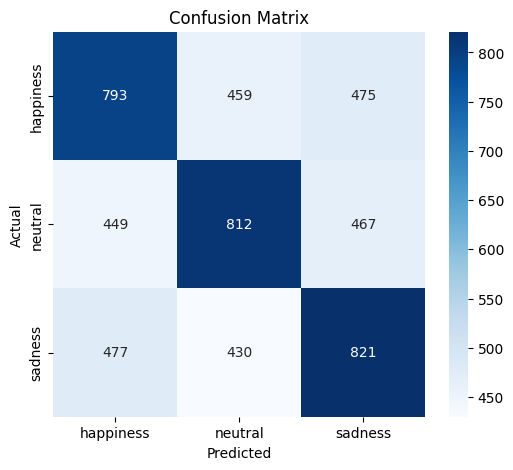


🔹 Classification Report:
              precision    recall  f1-score   support

   happiness       0.46      0.46      0.46      1727
     neutral       0.48      0.47      0.47      1728
     sadness       0.47      0.48      0.47      1728

    accuracy                           0.47      5183
   macro avg       0.47      0.47      0.47      5183
weighted avg       0.47      0.47      0.47      5183



In [ ]:
#confusion matrix
y_pred = OptimizedRNN.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = label_encoder.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#classification report
print("\n🔹 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


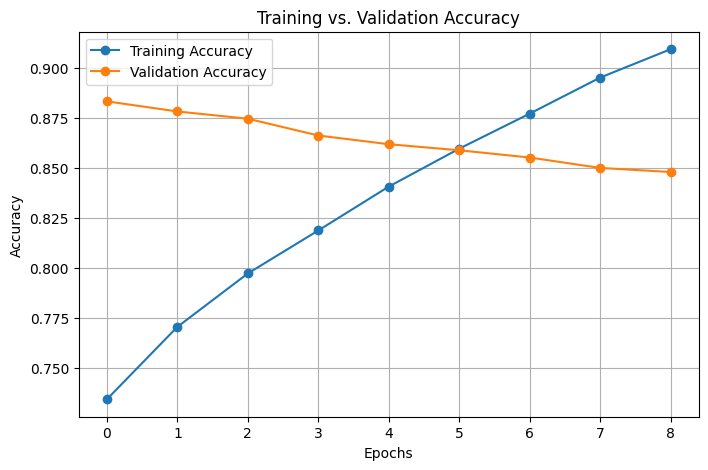

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("OptimizedRNN_Model.keras")
print("\n✅ Model loaded successfully!")


✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 23 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Sentiment prediction function
def predict_sentiment(text):

    processed_text = clean_text(text)

    text_seq = tokenizer.texts_to_sequences([processed_text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)

    prediction = loaded_model.predict(text_pad)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])

    print(f"\n🔹 Predicted Sentiment: {predicted_label[0]}")

# Example usage
new_tweet = "i am so sad"
predict_sentiment(new_tweet)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

🔹 Predicted Sentiment: sadness
